In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.generation.sampling import MaxPosteriorSampling

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, DistanceEstimator, MAFMOGDensityEstimator, MADEMOGDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler, VarianceSource)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KernelDensity

from torch.utils.data import DataLoader, TensorDataset
from torch.quasirandom import SobolEngine

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from uncertaintylearning.utils import functions, bounds as boundsx
from uncertaintylearning.utils.feature_generator import FeatureGenerator
from uncertaintylearning.utils.density_estimator import FixedSmoothKernelDensityEstimator
from uncertaintylearning.utils.density_picker import CrossValidator
from uncertaintylearning.utils.buffer import Buffer
from uncertaintylearning.utils.smo import init_buffer, optimize, make_feature_generator, one_step_acquisition

from copy import deepcopy
from itertools import product
functions

{'sinusoid': <function uncertaintylearning.utils.test_functions.sinusoid(X, noise)>,
 'multi_optima': <function uncertaintylearning.utils.test_functions.multi_optima(X, noise)>,
 'booth': <function uncertaintylearning.utils.test_functions.booth(X, noise)>,
 'levi_n13': <function uncertaintylearning.utils.test_functions.levi_n13(X, noise)>,
 'ackley200': <function uncertaintylearning.utils.test_functions.ackley200(X, noise)>,
 'ackley10': <function uncertaintylearning.utils.test_functions.ackley10(X, noise)>}

In [28]:
fct_name = 'levi_n13'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
def invsoftplus(x, beta=1):
    return 1. / beta * (torch.log((beta * x).exp() - 1))

X = (bounds[1] - bounds[0]) * torch.rand(1000, dim) + bounds[0]
Y = f(X_valid)
# X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
# Y = f(X)

## COMPARE WITH MANY SEEDS TO GP

Seed 0, Y_init_max -1.1537401676177979
Y_init_max -1.1537401676177979


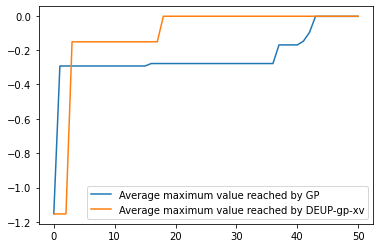

Seed 1, Y_init_max -0.5252314805984497
Y_init_max -0.5252314805984497


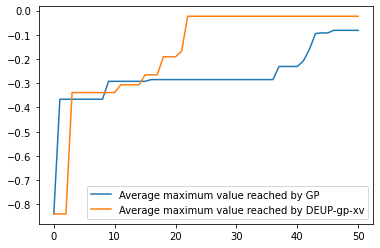

Seed 2, Y_init_max -0.1441899538040161
Y_init_max -0.1441899538040161


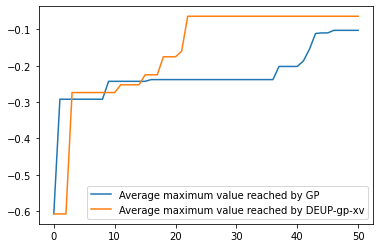

Seed 3, Y_init_max -4.7768940925598145
Y_init_max -4.7768940925598145


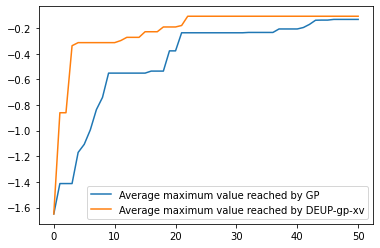

Seed 4, Y_init_max -3.258094072341919
Y_init_max -3.258094072341919


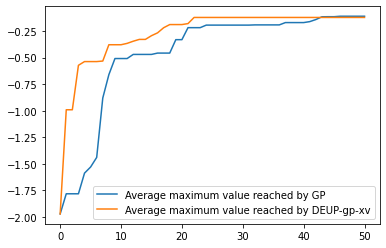

In [29]:
n_seeds = 5
n_steps = 50
res_gp = np.zeros((n_seeds, 1 + n_steps))
res_gpdeup = np.zeros((n_seeds, 1 + n_steps))
# res_nndeup = np.zeros((n_seeds, 1 + n_steps))
features = 'xv'

for seed in range(n_seeds):
    torch.manual_seed(10 + seed)
    X_init = (bounds[1] - bounds[0]) * torch.rand(init_points, dim) + bounds[0]
    Y_init = f(X_init)
    print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    outs_gp = optimize(f, bounds, X_init, Y_init, gp=True, plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    res_gp[seed] = outs_gp[0]

    
    
    print(f'Y_init_max {Y_init.max().item()}')
    networks = {
    'e_predictor': create_network(len(features) + (dim - 1 if 'x' in features else 0),
                                  1, 128, 'relu', False if use_log_unc else True, 3),
    'f_predictor': create_network(dim, 1, 128, 'relu', False, 3)
    }
    optimizers = {
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
             }
    outs = optimize(f, bounds, X_init, Y_init, networks=networks, optimizers=optimizers, features=features, plot_stuff=False,
                    n_steps=n_steps, epochs=200, domain=X, domain_image=Y, print_each=100, use_log_unc=True, estimator='gp')
    res_gpdeup[seed] = outs[0]
    
    plt.plot(range(1 + n_steps), res_gp[:seed+1].mean(0),  label='Average maximum value reached by GP')
    plt.plot(range(1 + n_steps), res_gpdeup[:seed+1].mean(0), label='Average maximum value reached by DEUP-gp-xv')
    # plt.plot(range(1 + n_steps), res_nndeup[:seed+1].mean(0), label='Average maximum value reached by DEUP-nn-xv')
    plt.legend()
    plt.show()


In [21]:
import pickle
string = """
multi_optima function, 5 seeds, 10..14, xv as features, 6 initial points, log uncertainty prediction, scaled variance on whole domain
"""
pickle.dump({'gp': res_gp, 'gpdeup': res_gpdeup, 'nndeup': res_nndeup, 'info': string}, open('pickles/levi_n13.pkl', 'wb'))

## ACKLEY10

	Initial Buffer targets:  tensor([-6.4719,  1.3335, -6.3491, -5.3983, -0.0252, -5.0744,  1.0000, -3.3307,
         1.3945, -3.2512, -2.8271,  0.3927, -8.5279, -8.3877, -3.4386, -4.2968,
        -5.5555, -0.7136, -4.9558,  2.2091,  1.2827, -5.2842, -0.2178, -1.5371,
        -5.4216,  0.3313, -6.0388, -8.7769, -4.9893,  1.3296,  0.9634, -7.1901,
        -0.9061, -4.6629,  1.1457, -0.2535, -1.9163, -5.8375, -2.8623, -5.2814,
        -6.9758, -5.3769,  1.5296, -0.4247, -4.0389, -8.2398,  0.8465, -0.0785,
         1.4355, -5.6493,  0.3501, -9.2515, -6.3587, -5.6200, -0.7571, -0.4867,
        -5.7636, -4.3975, -2.5040, -3.5512,  2.5959,  0.8254, -5.8590, -6.1357,
        -3.6867, -1.5276, -4.9582, -4.6750, -4.1780,  0.5573, -3.7646,  1.4405,
        -0.1085, -0.4311, -9.4458, -9.0541, -1.7225,  0.3697, -2.7990,  1.9516])
step 0, 20 datapoints seen
	Mean train error:  2.020897199583871e-10
	Mean domain error:  2.1039628982543945
	Mean predicted train unc:  0.009965643286705017
	Mean predicted

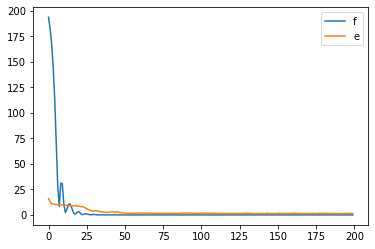

	Min buffer target:  -9.445837020874023 , max:  2.5958974361419678
step 1, 30 datapoints seen
	Mean train error:  5.036826678406214e-06
	Mean domain error:  1.954697608947754
	Mean predicted train unc:  2.4602373741799966e-05
	Mean predicted domain unc:  0.5754797458648682
	Mean train unc-error:  1.95655466086464e-05
	Mean domain unc-error:  8.733370780944824
	current max: -1.3307275772094727


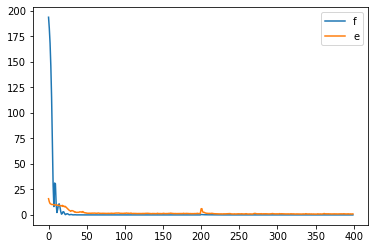

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 2, 40 datapoints seen
	Mean train error:  1.0078274499392137e-06
	Mean domain error:  1.6450026035308838
	Mean predicted train unc:  6.376812962116674e-05
	Mean predicted domain unc:  0.6725631952285767
	Mean train unc-error:  6.276030035223812e-05
	Mean domain unc-error:  6.513654708862305
	current max: -1.3307275772094727


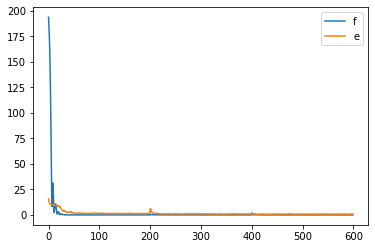

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 3, 50 datapoints seen
	Mean train error:  3.944912532460876e-05
	Mean domain error:  1.9484226703643799
	Mean predicted train unc:  0.0001536472700536251
	Mean predicted domain unc:  0.7272863984107971
	Mean train unc-error:  0.00011419816291891038
	Mean domain unc-error:  9.368724822998047
	current max: -1.3307275772094727


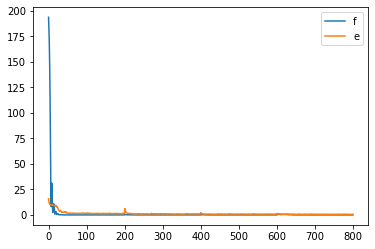

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 4, 60 datapoints seen
	Mean train error:  7.41945314075565e-06
	Mean domain error:  2.0237724781036377
	Mean predicted train unc:  0.00023252195387613028
	Mean predicted domain unc:  0.7120800018310547
	Mean train unc-error:  0.00022510251437779516
	Mean domain unc-error:  9.517778396606445
	current max: -1.3307275772094727


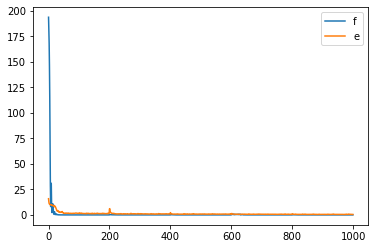

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 5, 70 datapoints seen
	Mean train error:  3.817791002802551e-05
	Mean domain error:  2.001168727874756
	Mean predicted train unc:  0.00028271088376641273
	Mean predicted domain unc:  0.8039219379425049
	Mean train unc-error:  0.0002445330028422177
	Mean domain unc-error:  9.20106315612793
	current max: -1.3307275772094727


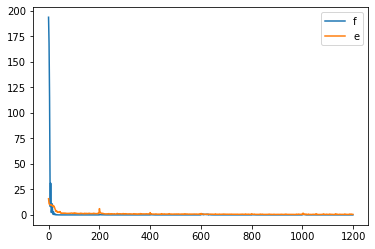

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 6, 80 datapoints seen
	Mean train error:  0.0016960020875558257
	Mean domain error:  1.806225299835205
	Mean predicted train unc:  0.0007614119676873088
	Mean predicted domain unc:  0.9159163236618042
	Mean train unc-error:  -0.0009345899452455342
	Mean domain unc-error:  8.472355842590332
	current max: -1.3307275772094727


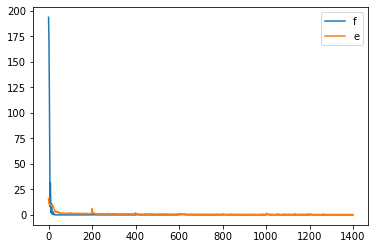

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 7, 90 datapoints seen
	Mean train error:  0.00126626156270504
	Mean domain error:  1.8675307035446167
	Mean predicted train unc:  0.0010815765708684921
	Mean predicted domain unc:  0.8779438138008118
	Mean train unc-error:  -0.00018468497728463262
	Mean domain unc-error:  8.972492218017578
	current max: -1.3307275772094727


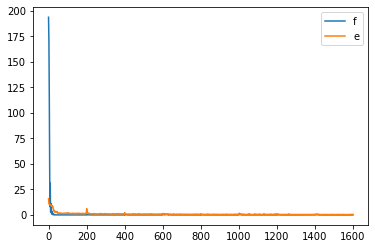

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 8, 100 datapoints seen
	Mean train error:  3.482721876935102e-05
	Mean domain error:  1.4849638938903809
	Mean predicted train unc:  0.0009693431784398854
	Mean predicted domain unc:  0.9735012650489807
	Mean train unc-error:  0.0009345159051008523
	Mean domain unc-error:  6.270195960998535
	current max: -1.3307275772094727


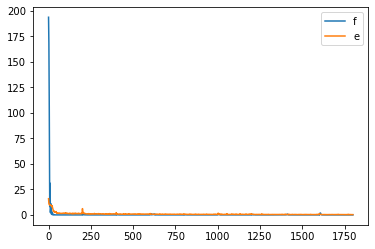

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 9, 110 datapoints seen
	Mean train error:  3.3676835755613865e-06
	Mean domain error:  1.361177921295166
	Mean predicted train unc:  0.0013389360392466187
	Mean predicted domain unc:  1.0912868976593018
	Mean train unc-error:  0.0013355679111555219
	Mean domain unc-error:  5.121805191040039
	current max: -1.3307275772094727


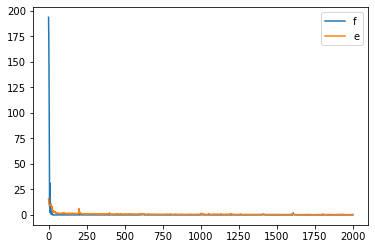

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 10, 120 datapoints seen
	Mean train error:  0.0008179708966054022
	Mean domain error:  1.2145181894302368
	Mean predicted train unc:  0.001243100268766284
	Mean predicted domain unc:  1.0270450115203857
	Mean train unc-error:  0.00042512963409535587
	Mean domain unc-error:  3.8997440338134766
	current max: -1.3307275772094727


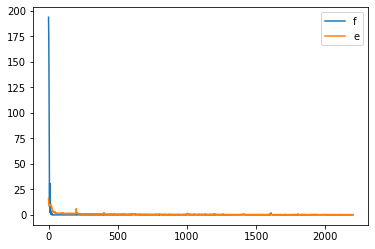

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 11, 130 datapoints seen
	Mean train error:  0.021064503118395805
	Mean domain error:  1.1862025260925293
	Mean predicted train unc:  0.003855276620015502
	Mean predicted domain unc:  0.9261578917503357
	Mean train unc-error:  -0.01720922812819481
	Mean domain unc-error:  3.5790510177612305
	current max: -1.3307275772094727


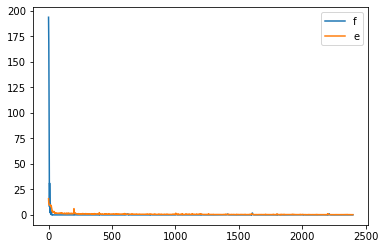

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 12, 140 datapoints seen
	Mean train error:  0.0002723314973991364
	Mean domain error:  1.1164644956588745
	Mean predicted train unc:  0.003265795297920704
	Mean predicted domain unc:  0.8534258604049683
	Mean train unc-error:  0.0029934640042483807
	Mean domain unc-error:  3.5987634658813477
	current max: -1.3307275772094727


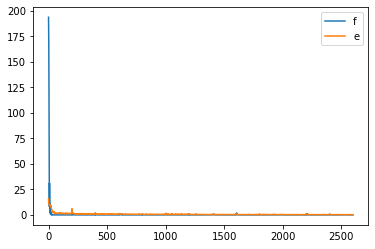

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 13, 150 datapoints seen
	Mean train error:  0.0001595749636180699
	Mean domain error:  1.0955610275268555
	Mean predicted train unc:  0.0029924006666988134
	Mean predicted domain unc:  0.7599387168884277
	Mean train unc-error:  0.0028328257612884045
	Mean domain unc-error:  3.406118631362915
	current max: -1.3307275772094727


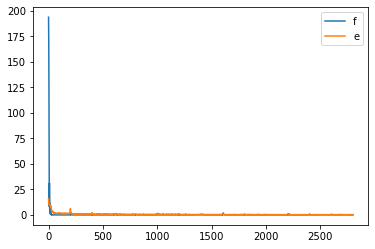

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 14, 160 datapoints seen
	Mean train error:  0.0031931456178426743
	Mean domain error:  0.9153127074241638
	Mean predicted train unc:  0.0036072186194360256
	Mean predicted domain unc:  0.8014883995056152
	Mean train unc-error:  0.0004140727105550468
	Mean domain unc-error:  2.607052803039551
	current max: -1.3307275772094727


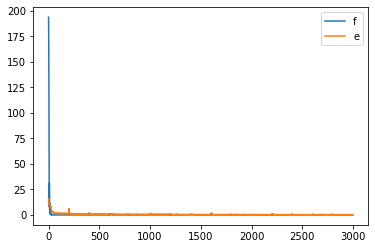

	Min buffer target:  -10.0 , max:  2.5958974361419678
step 15, 170 datapoints seen
	Mean train error:  0.002203095005825162
	Mean domain error:  0.8595913052558899
	Mean predicted train unc:  0.0007335214759223163
	Mean predicted domain unc:  0.9051163792610168
	Mean train unc-error:  -0.001469573238864541
	Mean domain unc-error:  2.6782755851745605
	current max: -1.3307275772094727


KeyboardInterrupt: 

In [25]:
fct_name = 'ackley10'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
init_points = 20
n_steps=100
q=10

features='xv'

X_init = (bounds[1] - bounds[0]) * torch.rand(init_points, dim) + bounds[0]
Y_init = f(X_init)

networks = {
    'e_predictor': create_network(len(features) + (dim - 1 if 'x' in features else 0),
                                  1, 128, 'relu', False if use_log_unc else True, 3),
    'f_predictor': create_network(dim, 1, 128, 'relu', False, 3)
    }
optimizers = {
          'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
          'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
         }

    
X_valid = (bounds[1] - bounds[0]) * torch.rand(1000, dim) + bounds[0]
Y_valid = f(X_valid)

optimize(f, bounds, X_init, Y_init, networks=networks, optimizers=optimizers, features=features, plot_stuff=True,
         q=q, n_steps=n_steps, epochs=200, domain=X_valid, domain_image=Y_valid, print_each=1, use_log_unc=True, estimator='nn')